In [1]:
#!usr/bin/python3 

import pandas as pd
import json
import matplotlib.pyplot as plt
from iso639 import languages
from textblob import TextBlob
import re
from wordcloud import WordCloud, STOPWORDS

In [2]:
tweets_data_path = '04_04_2018-tweet_extract.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

print ("Total Data Samples Present -", len(tweets_data))

Total Data Samples Present - 60000


In [3]:
tweets = pd.DataFrame(tweets_data, columns=["text","lang","country", "user"])
tweets.head()

,text,lang,country,user
0,RT @IndiaToday: Congress Spokesperson Prof Go...,en,NaN,"{'followers_count': 130, 'id_str': '465760189'..."
1,"RT @CNNnews18: ""If there was no BJP and Modi, ...",en,NaN,"{'followers_count': 655, 'id_str': '2277312042..."
2,RT @INCIndia: Instead of ensuring that the ben...,en,NaN,"{'followers_count': 710, 'id_str': '3022977911..."
3,"RT @inquestioner: Dei paavingala, konjom namba...",in,NaN,"{'followers_count': 4, 'id_str': '898483048001..."
4,@narendramodi @PMOIndia @AmitShahOffice https:...,und,NaN,"{'followers_count': 264, 'id_str': '2361342523..."


In [4]:
def get_phrase_sentiment(phrase):
    pattern2 = "(^RT @\w+.)"
    d = re.findall(pattern2,phrase)
    for i in d:
        phrase.replace(i,"")
    temp = ""
    for letter in phrase:
        if letter.isalnum() or " ":
            temp+= letter
    phrase = temp
    
    analysis = TextBlob(phrase)
    if analysis.sentiment.polarity > 0:
        return 'positive', float(format(analysis.sentiment.polarity, '.3f'))
    elif analysis.sentiment.polarity == 0:
        return 'neutral', float(format(analysis.sentiment.polarity, '.3f'))
    else:
        return 'negative', float(format(analysis.sentiment.polarity, '.3f'))
    
tweets["tweet_sentiment"] = tweets.text.apply(get_phrase_sentiment)
tweets["sentiment_type"] = tweets.tweet_sentiment.apply(lambda i:i[0])
tweets["sentiment_value"] = tweets.tweet_sentiment.apply(lambda i:i[1])
tweets.head()

,text,lang,country,user,tweet_sentiment,sentiment_type,sentiment_value
0,RT @IndiaToday: Congress Spokesperson Prof Go...,en,NaN,"{'followers_count': 130, 'id_str': '465760189'...","(positive, 0.136)",positive,0.136
1,"RT @CNNnews18: ""If there was no BJP and Modi, ...",en,NaN,"{'followers_count': 655, 'id_str': '2277312042...","(neutral, 0.0)",neutral,0.000
2,RT @INCIndia: Instead of ensuring that the ben...,en,NaN,"{'followers_count': 710, 'id_str': '3022977911...","(neutral, 0.0)",neutral,0.000
3,"RT @inquestioner: Dei paavingala, konjom namba...",in,NaN,"{'followers_count': 4, 'id_str': '898483048001...","(neutral, 0.0)",neutral,0.000
4,@narendramodi @PMOIndia @AmitShahOffice https:...,und,NaN,"{'followers_count': 264, 'id_str': '2361342523...","(neutral, 0.0)",neutral,0.000


neutral     34292
positive    14594
negative    11114
Name: sentiment_type, dtype: int64


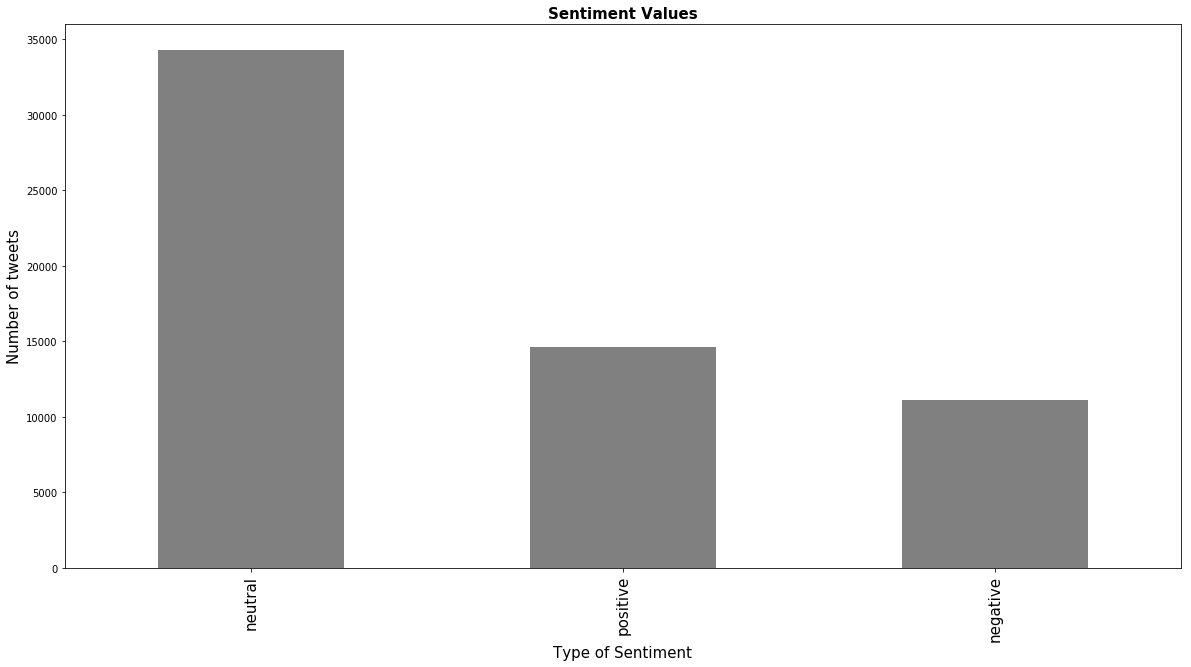

In [5]:
senti_types = tweets['sentiment_type'].value_counts()
ig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Type of Sentiment', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Sentiment Values', fontsize=15, fontweight='bold')
senti_types.plot(ax=ax, kind='bar', color='grey', figsize=(20,10))
print(senti_types)
plt.show()

In [6]:
df_positive = tweets
df_positive["sentiment_value"] = df_positive.sentiment_value.apply(lambda i:float(i))
positive_tweets = df_positive[df_positive["sentiment_value"]>0]
positive_tweets.head()

,text,lang,country,user,tweet_sentiment,sentiment_type,sentiment_value
0,RT @IndiaToday: Congress Spokesperson Prof Go...,en,NaN,"{'followers_count': 130, 'id_str': '465760189'...","(positive, 0.136)",positive,0.136
8,RT @RohanSameerRoy: @ArvindKejriwal Big Story ...,en,NaN,"{'followers_count': 1901, 'id_str': '318377056...","(positive, 0.1)",positive,0.100
14,RT @postcard_news: Fantastic explanation by Hu...,en,NaN,"{'followers_count': 422, 'id_str': '7586511228...","(positive, 0.891)",positive,0.891
25,RT @shashank_rekala: @RahulGandhi Since 2014 M...,en,NaN,"{'followers_count': 2545, 'id_str': '847188880...","(positive, 0.2)",positive,0.200
30,"RT @INCIndia: ""The much-touted phrase of PM Mo...",en,NaN,"{'followers_count': 38, 'id_str': '84677166734...","(positive, 0.4)",positive,0.400


INDIA                   4481
Location Unavailable    4280
DELHI                    420
भारत                     281
MUMBAI                   270
BANGALORE                158
CHENNAI                  110
BHARAT                    99
HYDERABAD                 96
USA                       95
Name: location, dtype: int64


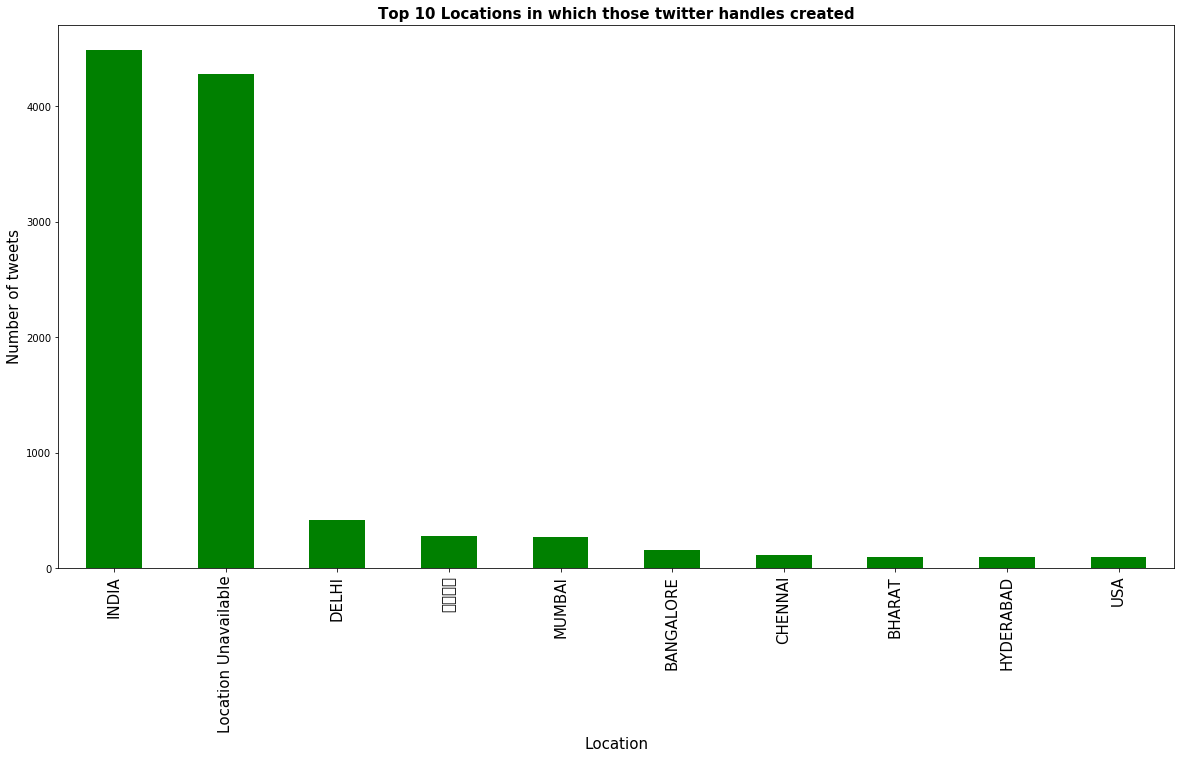

In [7]:
def handle_location_used(string):
    try:
        string = str(string)
        res = eval(string)["location"]
        return str(res.split()[-1]).upper()
    except:
        return "Location Unavailable"
    
handles_by_location = pd.DataFrame()
handles_by_location["location"] = positive_tweets.user.apply(handle_location_used)
t_b_l_5 = handles_by_location["location"].value_counts()[:10]
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Location', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 10 Locations in which those twitter handles created', fontsize=15, fontweight='bold')
t_b_l_5.plot(ax=ax, kind='bar', color='green', figsize=(20,10))
print(t_b_l_5[:10])
plt.show()

No Profile Image Available                                                                   1252
http://pbs.twimg.com/profile_images/951885952284164096/ZCyEqqOP_normal.jpg                     73
http://pbs.twimg.com/profile_images/974387805324480512/5hIokSMp_normal.jpg                     22
http://pbs.twimg.com/profile_images/966212508146130944/l7vSOfcR_normal.jpg                     16
http://pbs.twimg.com/profile_images/900599926819704832/AgzQHIYg_normal.jpg                     16
http://pbs.twimg.com/profile_images/1714952350/promoting-your-brand-on-twitter_normal.jpg      15
http://pbs.twimg.com/profile_images/581821098003681280/ym_OIlTB_normal.jpg                     15
http://pbs.twimg.com/profile_images/955612299171045376/NAMW2CLZ_normal.jpg                     14
http://pbs.twimg.com/profile_images/941255990330011648/_1jd1_dh_normal.jpg                     13
http://pbs.twimg.com/profile_images/672370402560053248/EcGUmaBW_normal.jpg                     13
Name: image_availabi

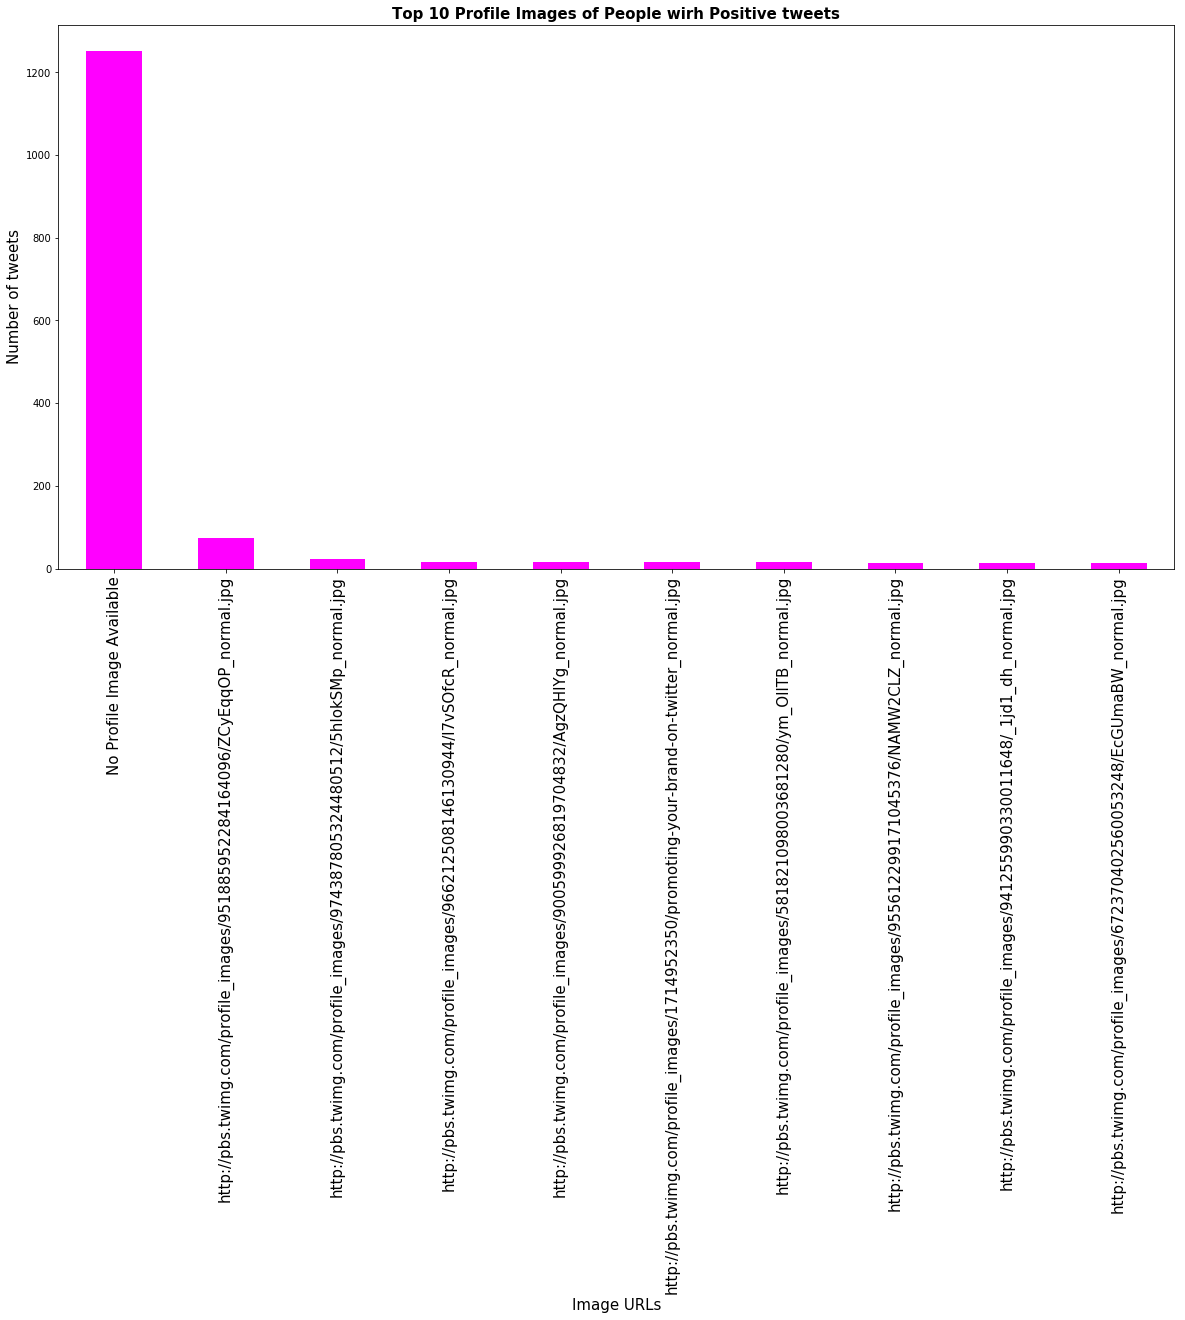

In [8]:
def handle_has_image(string):
    try:
        string=str(string)
        res = eval(string)["profile_image_url"]
        if "default_profile_normal.png" not in res:
            
            return res
        else:
            return "No Profile Image Available"
    except:
        return "No Profile Image Available"
    
handles_image_availability = pd.DataFrame()
handles_image_availability["image_availability"] = positive_tweets.user.apply(handle_has_image)
t_b_l_5 = handles_image_availability["image_availability"].value_counts()[:10]
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Image URLs', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 10 Profile Images of People wirh Positive tweets', fontsize=15, fontweight='bold')
t_b_l_5.plot(ax=ax, kind='bar', color='magenta', figsize=(20,10))
print(t_b_l_5[:10])
plt.show()

@PMNamo_            73
@Georgekurian4K     22
@akshaychandorka    16
@jayasri1974        16
@sameherealso       15
@babun1515          15
@prayag             14
@jadumantar         13
@PDrsudhakar        13
@AnimalsBelize      13
Name: screen_name, dtype: int64


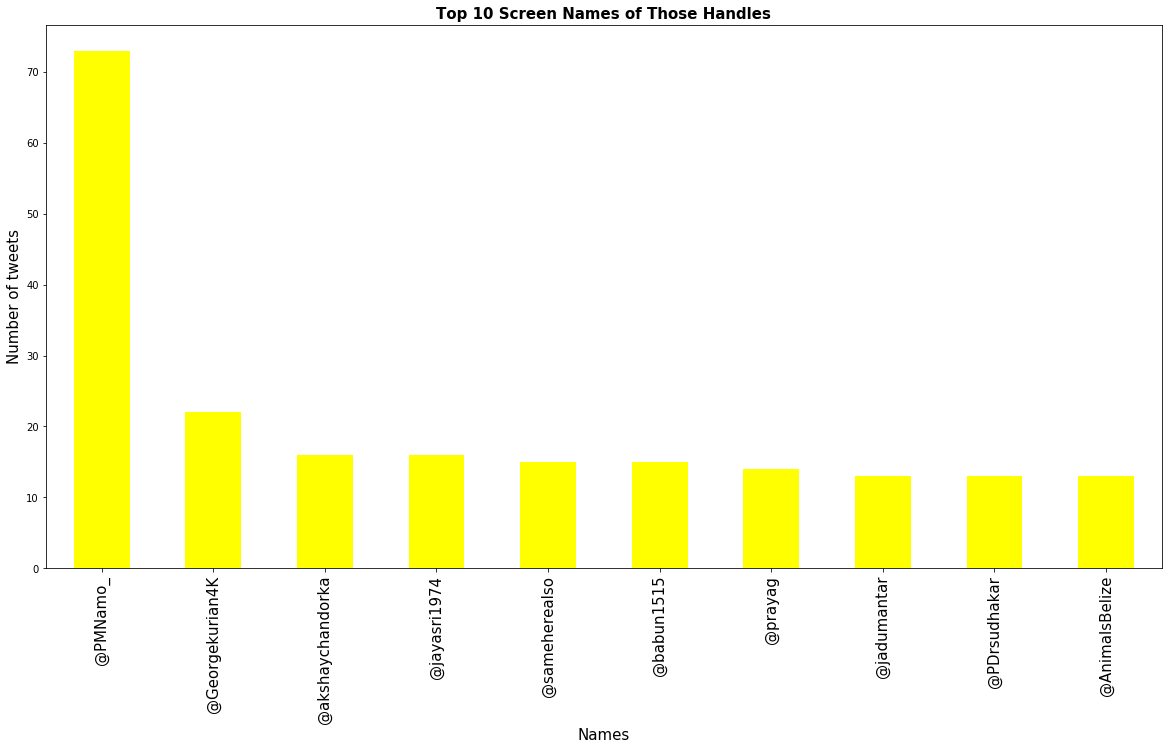

In [9]:
def handle_name(string):
    try:
        string = str(string)
        res = eval(string)["screen_name"]
        return "@"+res
    except:
        return None
    
handles_names = pd.DataFrame()
handles_names["screen_name"] = positive_tweets.user.apply(handle_name)
t_b_l_5 = handles_names["screen_name"].value_counts()[:10]
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Names', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 10 Screen Names of Those Handles', fontsize=15, fontweight='bold')
t_b_l_5.plot(ax=ax, kind='bar', color='yellow', figsize=(20,10))
print(t_b_l_5[:10])
plt.show()

2017    2315
2010    1625
2009    1487
2016    1459
2015    1418
2014    1381
2013    1301
2011    1226
2018    1179
2012    1011
Name: year, dtype: int64


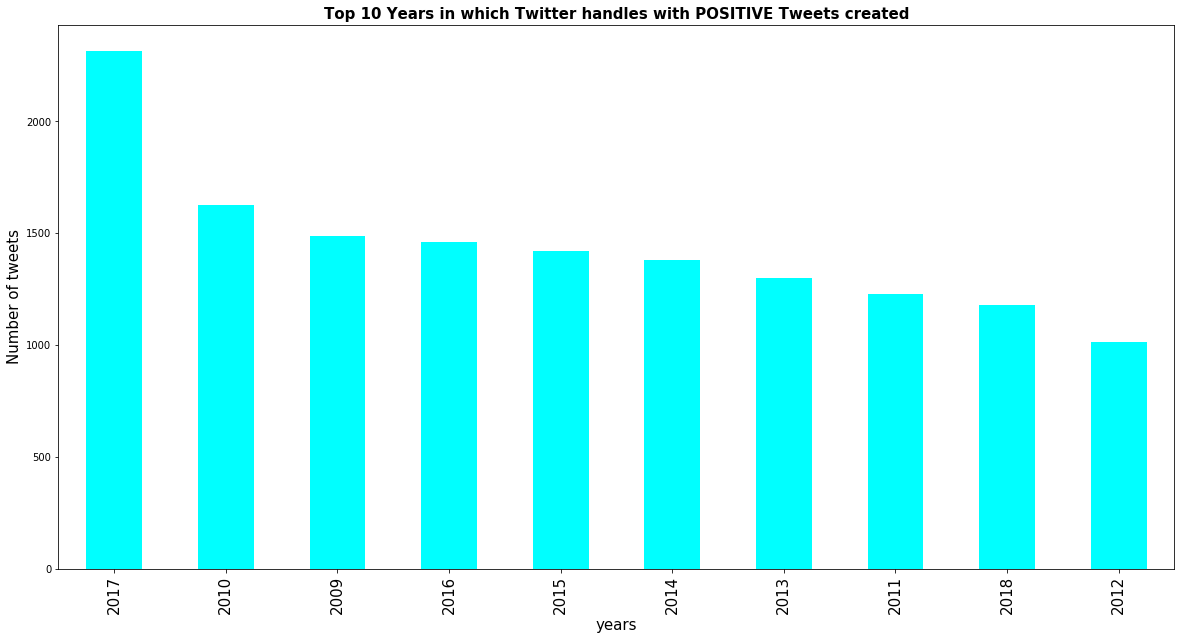

In [10]:
def handle_created_year(string):
    string = str(string)
    try:
        res = eval(string)["created_at"]
        return str(res.split()[-1])
    except:
        return "Year Unavailable"
    
handles_by_year = pd.DataFrame()
handles_by_year["year"] = positive_tweets.user.apply(handle_created_year)
t_b_l_5 = handles_by_year["year"].value_counts()[:10]
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('years', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 10 Years in which Twitter handles with POSITIVE Tweets created', fontsize=15, fontweight='bold')
t_b_l_5.plot(ax=ax, kind='bar', color='cyan', figsize=(20,10))
print(t_b_l_5[:10])
plt.show()

In [11]:
def find_positive_hash_words(string):
    pattern = r"#\w+"
    d = re.findall(pattern,string)
    if d == []:
        return None
    else:
        d = [i.lower() for i in d]
        return d
    
positive_hash_words = pd.DataFrame()
positive_hash_words["positive_words"] = positive_tweets.text.apply(find_positive_hash_words)
list_positive_words = positive_hash_words["positive_words"].tolist()
list_positive_words = [j for j in list_positive_words if j!= None]
list_positive_words = [k for l in list_positive_words for k in l]
positive_words_100 = pd.Series(list_positive_words).value_counts()[:100]
positive_words_100_list = positive_words_100.index.values
print("Top 10 Hash words in positive tweets - ", positive_words_100_list[:10])

Top 10 Hash words in positive tweets -  ['#fakenews' '#bharatkibaatsabkesaath' '#petrolled' '#modi'
 '#transformingindia' '#blackbuckpoachingcase' '#uturnunclencbn'
 '#salmankhan' '#blackbuckpoaching' '#fakenewsissue']


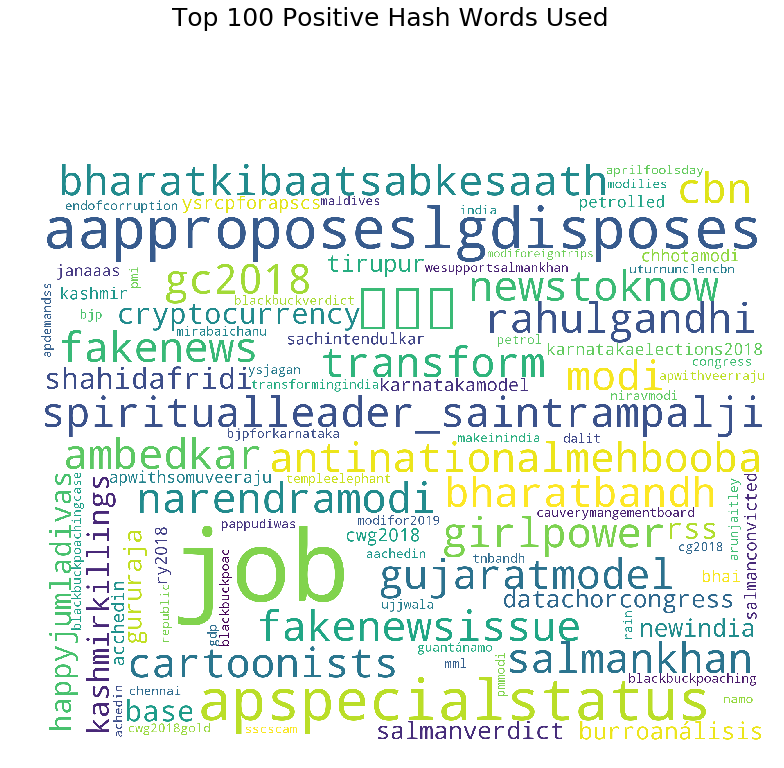

In [12]:
def wordcloud_figure(data, color = 'black'):
    cleaned_word = [word.replace(":","") for word in data]
    cleaned_word = [word.replace("?","") for word in data]
    cleaned_word = [word.replace(";","") for word in data]
    cleaned_word = [word.replace(",","") for word in data]
    #cleaned_word = [word.replace("#","") for word in data]
    new_data = " ".join(cleaned_word)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(new_data)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    if color=="white":
        plt.suptitle("Top 100 Positive Hash Words Used", fontsize=25)
    if color=="red":
        plt.suptitle("Top 100 Negative Hash Words Used", fontsize=25)
    if color not in ["red","white"]:
        plt.suptitle("Top 100 Neutral Hash Words Used", fontsize=25)
    plt.show()
    
wordcloud_figure(positive_words_100_list,'white')